In [27]:
import os
import re
import numpy as np
import pandas as pd
import pickle as pkl

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
LYRICS_DIR = 'lyrics/'
BANDS_DIR = 'bands/'
test_filename = 'lyrics/cynic.pkl'

In [31]:
def getwords(filename):
    with open(filename, 'rb') as f:
        lyrics = pkl.load(f)
    words = []
    for album, album_lyrics in lyrics.items():
        for song, song_lyrics in album_lyrics.items():
            for line in song_lyrics:
                for w in line.split():
                    s = re.search("(\w+)|(\w+([-'])(\w+)?[']?(\w+))", w.lower())
                    if s:
                        w = s.group()
                        if w in english_vocab and w not in stop_words:
                            words.append(w)
    return words

In [32]:
def tf(t, d):
    return np.log10(1 + d.count(t) / float(len(d)))

def idf(t, D):
    N = len(D)
    N_t = len([d for d in D if t in d])
    return np.log10(N / float(N_t))

def tf_idf(t, d, D):
    return tf(t, d) * idf(t, D)

def multi_tf(d):
    t_all = sorted(set(d))
    return {t: tf(t, d) for t in t_all}

def multi_idf(D):
    t_all = sorted(set([w for words in D for w in words]))
    N = len(D)
    N_t = np.array([len([d for d in D if t in d]) for t in t_all]).astype(float)
    return dict(zip(t_all, np.log10(N / N_t)))

def multi_tf_idf(d, D):
    t_all = sorted(set([w for words in D for w in words]))
    tf_dict = multi_tf(d)
    idf_dict = multi_idf(D)
    return {t: tf_dict.get(t, 0) * idf_dict.get(t, 1) for t in t_all}

In [403]:
filenames = [f for f in os.listdir(LYRICS_DIR) if '.pkl' in f]
filenames_test = filenames[::5]
filenames_train = [f for f in filenames if f not in filenames_test]
words_dict = {}
for filename in filenames_train:
    words = getwords(os.path.join(LYRICS_DIR, filename))
    words_dict[filename.replace('.pkl', '')] = words
bands = words_dict.keys()
documents = list(words_dict.values())
corpus = [' '.join(d) for d in documents]
vocabulary = sorted(set([w for words in documents for w in words]))

In [285]:
# tf_idf_dict = multi_tf_idf(words_dict['abigail'], documents)
# sorted(tf_idf_dict.items(), key=lambda kv: -kv[1])[:10]

[('metal', 0.006613481756050381),
 ('beer', 0.003193356166350265),
 ('pussy', 0.0029660363590650056),
 ('satanik', 0.0029660363590650056),
 ('bitch', 0.0019927418358256237),
 ('slut', 0.0017551412758137295),
 ('fuck', 0.0016436340032267417),
 ('666', 0.0015996131597929583),
 ('poser', 0.0015996131597929583),
 ('yakuza', 0.0015996131597929583)]

In [408]:
vectorizer = TfidfVectorizer(stop_words=stop_words, vocabulary=vocabulary)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'themselves', 'weren', 'any', 'haven', 'the', 'his', "you've", 'nor', 'doesn', 'what', 'more', 'in', 'into', 'just', 'her', 'was', 'had', 'further', "you'll", 'be', 'needn', 'has', 'for', 'same', 'now', "wasn't", "shouldn't", 'then', 'between', 'most', 'o', 'shan', 'should', 'm', "mustn'...'have', 'few', 'over', "needn't", "didn't", 'being', 'y', 'while', 'did', 'mustn', 'those', 'doing'},
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=['aa', 'aal', 'aaron', 'ab', 'aba', 'abacus', 'abaft', 'abandon', 'abandoned', 'abandonment', 'abase', 'abased', 'abasement', 'abash', 'abashed', 'abate', 'abattoir'

In [532]:
# X = vectorizer.transform([' '.join(words_dict['aborted'])])
X = vectorizer.transform([' '.join(getwords(test_filename))])

tf_idf_dict = {v: X[0, vectorizer.vocabulary_[v]] for v in vocabulary}
print(sorted(tf_idf_dict.items(), key=lambda kv: -kv[1])[:10])

[('maya', 0.38161743494042394), ('kindly', 0.19163136123389118), ('space', 0.18178505432567457), ('integral', 0.16518370680716207), ('elves', 0.15019307870170645), ('one', 0.13060858927488886), ('om', 0.11815089049110825), ('life', 0.11614994114151461), ('bent', 0.11429588519373705), ('orbit', 0.10301470949177852)]


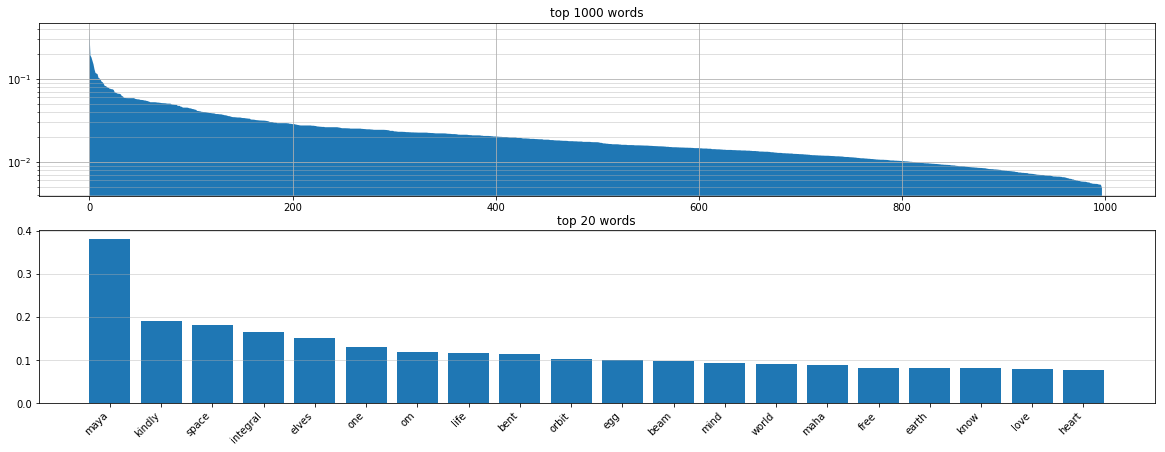

In [410]:
plt.figure(figsize=(20, 7))

values = sorted(tf_idf_dict.items(), key=lambda kv: -kv[1])
x_labels = np.array([v[0] for v in values])
y = np.array([v[1] for v in values])
x_labels = x_labels[:1000]
y = y[:1000]
x = range(len(y))
plt.subplot(2, 1, 1)
plt.fill_between(x=x, y1=0, y2=y)
plt.yscale('log')
plt.grid()
plt.grid(which='minor', alpha=0.5)
plt.title('top 1000 words')

x_labels = x_labels[:20]
y = y[:20]
x = range(len(y))
plt.subplot(2, 1, 2)
plt.bar(x, y)
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.title('top 20 words')
plt.show()

In [413]:
df = pd.DataFrame.from_dict(tf_idf_dict, orient='index').transpose()
df.index = ['cynic']
df

,aa,aal,aaron,ab,aba,abacus,abaft,abandon,abandoned,abandonment,...,zone,zoned,zoo,zoological,zoom,zoon,zoophilism,zulu,zwitter,zygote
cynic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [511]:
bands_train = [f.replace('.pkl', '') for f in filenames_train]
corpus_train = [' '.join(getwords(os.path.join(LYRICS_DIR, f))) for f in filenames_train]
X_train = vectorizer.transform(corpus_train).toarray()
df_train = pd.DataFrame(X_train, columns=vocabulary)
df_train 

,aa,aal,aaron,ab,aba,abacus,abaft,abandon,abandoned,abandonment,...,zone,zoned,zoo,zoological,zoom,zoon,zoophilism,zulu,zwitter,zygote
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.005845,0.000000,0.00000,...,0.012972,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.004070,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.007558,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015594,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.028707,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.021957,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [526]:
bands_test = [f.replace('.pkl', '') for f in filenames_test]
corpus_test = [' '.join(getwords(os.path.join(LYRICS_DIR, f))) for f in filenames_test]
X_test = vectorizer.transform(corpus_test).toarray()
df_test = pd.DataFrame(X_test, columns=vocabulary)
df_test 

,aa,aal,aaron,ab,aba,abacus,abaft,abandon,abandoned,abandonment,...,zone,zoned,zoo,zoological,zoom,zoon,zoophilism,zulu,zwitter,zygote
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.034528,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.184173,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.012268,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.017008,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.005250,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.026012,0.0,0.0,0.0,0.0,0.0,0.0,0.0
